In [1]:
import deepblink as pink
import numpy as np
import pandas as pd
import scipy
import skimage.io

In [2]:
!deepblink download -i particle

# Colocalization: combining predictions from different channels

deepBlink is only able to predict on a single 2D image at a time. Therefore, additional tools have to be used if colocalization (the assignment of spots from different channels) should be performed.

### Step 1: Loading image and model

First, lets begin by loading a pre-trained model and example image into memory using deepBlink and scikit-image respectively.

We will use c1 as reference channel to which spots from c2 can be assigned.

In [3]:
image_c1 = skimage.io.imread("./image_c1.tif")
image_c2 = skimage.io.imread("./image_c2.tif")
image_c1.shape

(512, 512)

In [4]:
model = pink.io.load_model("./particle.h5")

### Step 2: Spot detection

Next, we can predict the spot coordinate locations for both images.

In [5]:
pred_c1 = pink.inference.predict(image=image_c1, model=model)
pred_c2 = pink.inference.predict(image=image_c2, model=model)

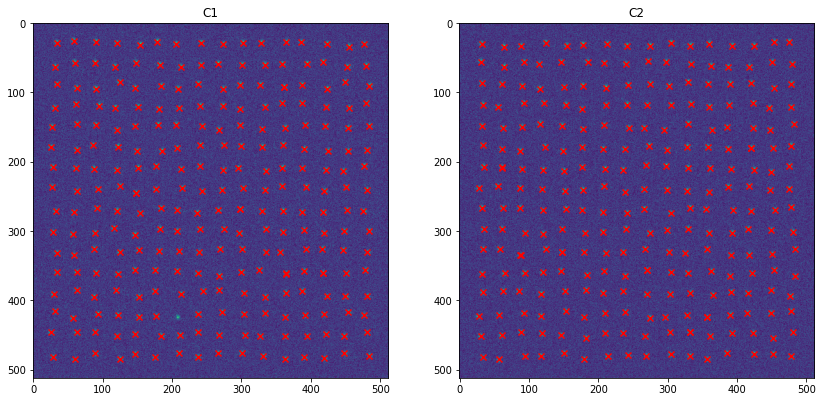

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].set_title("C1")
ax[0].imshow(image_c1)
ax[0].scatter(x=pred_c1.T[1], y=pred_c1.T[0], marker="x", c="r")
ax[1].set_title("C2")
ax[1].imshow(image_c2)
ax[1].scatter(x=pred_c2.T[1], y=pred_c2.T[0], marker="x", c="r")
plt.show()

### Step 3: Colocalization

Colocalization contains the following key requirements:
* Spots that are the closest should be linked
* One-to-one pairing across channels
* Distances above a pre-defined distance are ignored

1. Calculate a euclidean distance matrix indicating the distance between all spots. This matrix can be visualized as well.

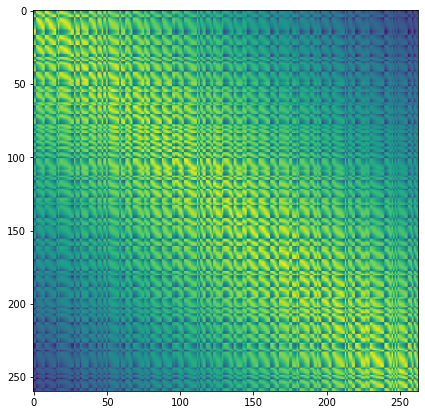

In [7]:
cdist = scipy.spatial.distance.cdist(pred_c1, pred_c2, metric="euclidean")

plt.figure(figsize=(7, 7))
plt.imshow(1-cdist)
plt.show()

2. Linear sum assignment to ensure one-to-one pairing taking distances as cost.

In [8]:
rows, cols = scipy.optimize.linear_sum_assignment(cdist)

3. Removal of distance above the defined cutoff. This might remove valid spot pairings if set too small.

In [9]:
distance_cutoff = 10

n_delete = 0
for r, c in zip(rows, cols):
    if cdist[r, c] > distance_cutoff:
        rows = rows[rows != r]
        cols = cols[cols != c]
        n_delete += 1
    
print(f"Deleted {n_delete} items.")

Deleted 17 items.


4. Return the final list of coordinates.

In [10]:
coords_c1 = np.array([pred_c1[i] for i in rows])
coords_c2 = np.array([pred_c2[i] for i in cols])

To visualize the results, we can plot a line between both coordinates as was done below.

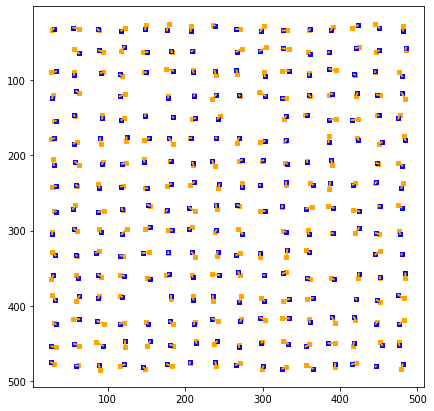

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))

for (c1_x, c1_y), (c2_x, c2_y) in zip(coords_c1, coords_c2):
    ax.scatter(c1_x, c1_y, s=10, c="orange", marker="s")
    ax.plot([c1_x, c2_x], [c1_y, c2_y], c="orange", linewidth=2)
    ax.scatter(c2_x, c2_y, s=10, c="b", marker="s")

ax.invert_yaxis()
plt.show()

### Summary

Given the lists of coordinates above, one can now continue with downstream processing:
* Percentages of spots close to another one
* Overall percentage using the original list of coordinates `pred_c1/2`